In [1]:
!pip install dmslogo
!pip install bottleneck

from google.colab import output
output.clear()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
tqdm.pandas()

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import dmslogo

No GPU available


In [ ]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

# class utils():
##     @staticmethod
#     def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
#         seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
#         for letterIdx, letter in enumerate(sequence_str):
#             seq_tensor[vocab_list.index(letter), letterIdx] = 1
#         seq_tensor = torch.Tensor(seq_tensor)
#         return seq_tensor

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

# Load CODA library and contributions

In [ ]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

In [ ]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

cell_types = ['K562', 'HepG2', 'SKNSH']

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

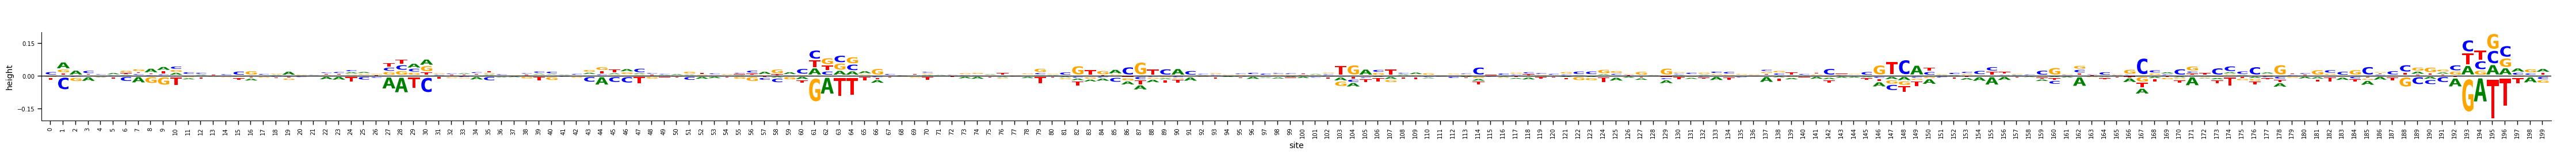

In [ ]:
plot_tensor = all_hyp_contributions[0, 0, ...]
matrix_to_dms(plot_tensor, y_max=0.2)
plt.show()

# Motif instances with hypothetical-score motifs

In [ ]:
motif_hyp_scores_dict = torch.load("/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_hyp_scores.pt")

motif_ids = list(motif_hyp_scores_dict.keys())
fwd_motif_hyp_scores = list(motif_hyp_scores_dict.values())
rev_motif_hyp_scores = [utils.reverse_complement_onehot(motif) for motif in fwd_motif_hyp_scores]

In [ ]:
custom_motif_names = ['GATA3', 'ELK4', 'FOSB::JUNB', 'HNF1B', 'HNF4A', 'CREB1', 'RELA', 'SP1', 'TEAD4',
                      'TP53', 'IRF4', 'STAT1', 'FOXB1', 'NR5A1', 'DBP', 'SOX4', 'SREBF2', 'FOXI1',
                      'TCF7L1', 'EHF', 'FOXJ2', '*NRF1', 'IRF3', 'NFATC2 x2', 'TYY1', 'NRF1', 'POU3F4', 'MEF2B',
                      'GFI1B', 'ID4', '*NFIB', 'STREME_1', 'STREME_2', 'MEIS2', 'STREME_4', '*HSF1'
                      ]

# Trying Pearson sweeps

In [ ]:
def pearson_correlation_windows(tensor, filter):
    filter_len = filter.shape[-1]
    # Reshape the filter to match the window shape
    filter = filter.view(1, 1, 4, filter_len)

    # Reshape the tensor to have windows as separate dimensions
    tensor = tensor.view(-1, 1, 4, filter_len)

    # Normalize input and filter to zero mean and unit variance
    tensor_normalized = (tensor - tensor.mean(dim=-1, keepdim=True)) / tensor.std(dim=-1, keepdim=True)
    filter_normalized = (filter - filter.mean()) / filter.std()

    # Compute element-wise product
    elementwise_product = tensor_normalized * filter_normalized

    # Compute Pearson correlation
    pearson_corr = F.avg_pool2d(elementwise_product, kernel_size=(4, filter_len), stride=1)

    return pearson_corr.squeeze(1).squeeze(2)


In [ ]:
all_motif_lengths = np.array([scores.shape[-1] for scores in fwd_motif_hyp_scores])
for window_len in np.unique(all_motif_lengths):
    print(window_len, np.where(all_motif_lengths == window_len)[0])

7 [17]
9 [ 0  5  8 11 15]
10 [ 1 16 20 26 28 30 33 34 35]
11 [ 2  7 19 21 29 32]
12 [ 6 14 18 23 24 27]
13 [ 4 31]
14 [10 13 25]
17 [3]
18 [ 9 22]
19 [12]


1 - pos_core_27b
K562: 663 instances
HepG2: 4926 instances
SKNSH: 43 instances


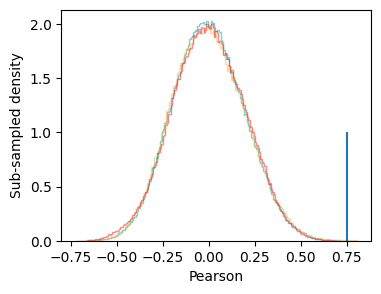


2 - pos_core_0b
K562: 64497 instances
HepG2: 187 instances
SKNSH: 113 instances


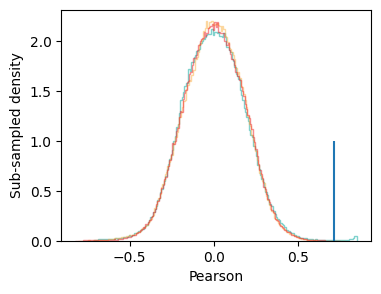


3 - pos_core_5
K562: 46355 instances
HepG2: 44200 instances
SKNSH: 48751 instances


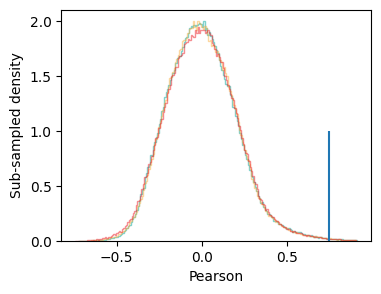


4 - pos_core_10b
K562: 2 instances
HepG2: 3231 instances
SKNSH: 20976 instances


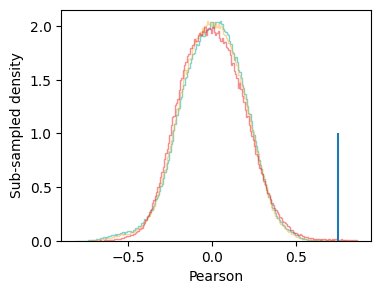


5 - pos_core_15
K562: 13893 instances
HepG2: 908 instances
SKNSH: 2831 instances


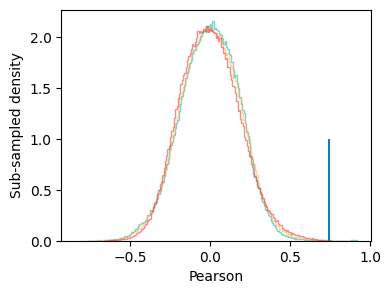


6 - pos_core_23b
K562: 0 instances
HepG2: 3750 instances
SKNSH: 396 instances


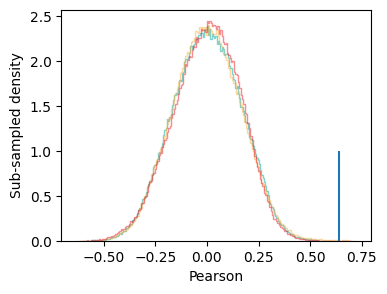


7 - pos_core_1
K562: 27397 instances
HepG2: 41877 instances
SKNSH: 39992 instances


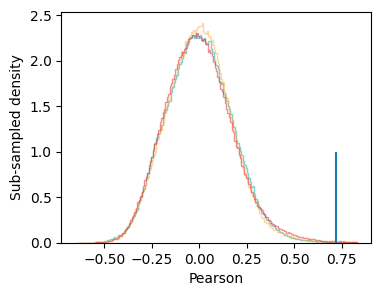


8 - pos_core_26
K562: 3298 instances
HepG2: 6421 instances
SKNSH: 6736 instances


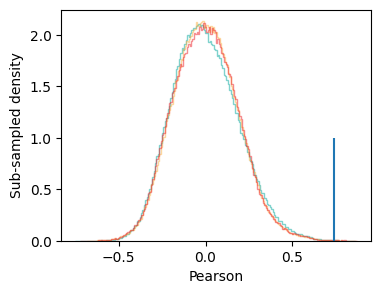


9 - pos_core_32b
K562: 12 instances
HepG2: 5099 instances
SKNSH: 18 instances


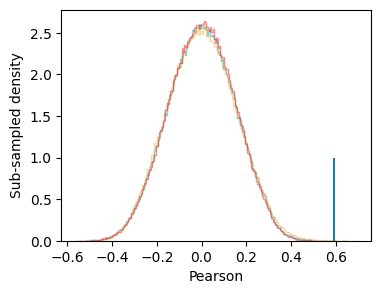


10 - pos_core_51b
K562: 1467 instances
HepG2: 695 instances
SKNSH: 362 instances


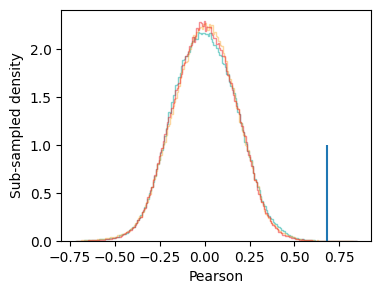


11 - neg_core_0
K562: 54516 instances
HepG2: 9527 instances
SKNSH: 1251 instances


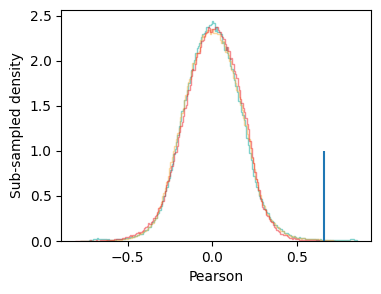


12 - neg_core_6
K562: 43270 instances
HepG2: 35309 instances
SKNSH: 12743 instances


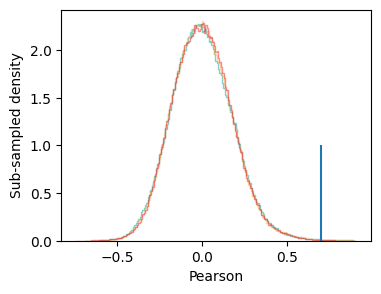


13 - streme_cluster__10_22_38
K562: 2136 instances
HepG2: 28190 instances
SKNSH: 32641 instances


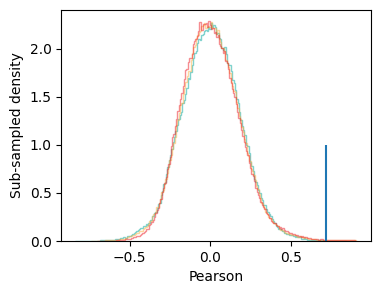


14 - streme_cluster__37
K562: 27316 instances
HepG2: 29108 instances
SKNSH: 20554 instances


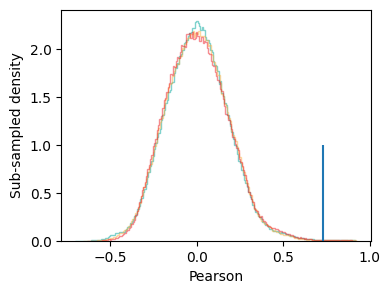


15 - streme_cluster__42
K562: 2977 instances
HepG2: 11024 instances
SKNSH: 3505 instances


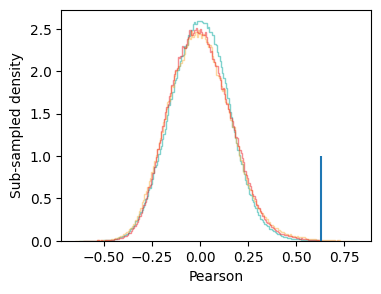


16 - pos_core_2
K562: 52078 instances
HepG2: 65437 instances
SKNSH: 68683 instances


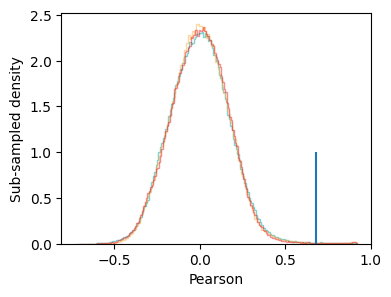


17 - pos_core_7
K562: 17320 instances
HepG2: 10616 instances
SKNSH: 10166 instances


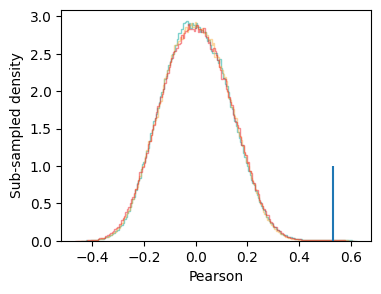


18 - pos_core_31
K562: 29374 instances
HepG2: 40874 instances
SKNSH: 43226 instances


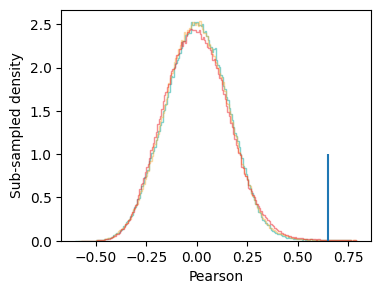


19 - pos_core_33
K562: 658 instances
HepG2: 306 instances
SKNSH: 351 instances


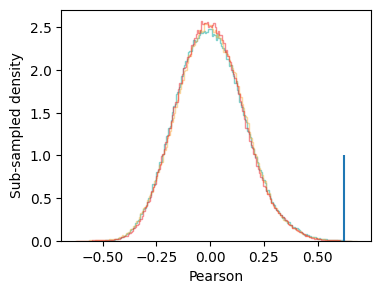


20 - neg_core_5
K562: 36008 instances
HepG2: 38644 instances
SKNSH: 72441 instances


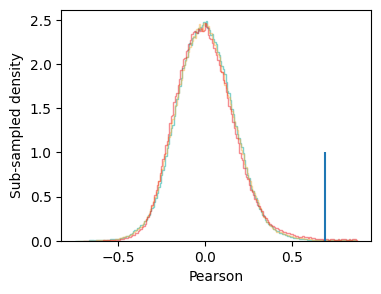


21 - streme_cluster__8_19_44
K562: 35638 instances
HepG2: 53865 instances
SKNSH: 9301 instances


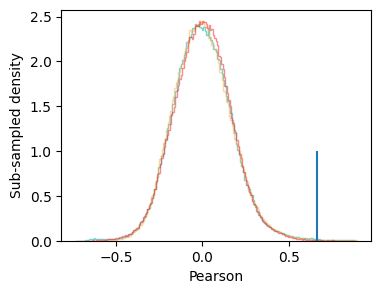


22 - pos_core_6
K562: 13196 instances
HepG2: 29548 instances
SKNSH: 32143 instances


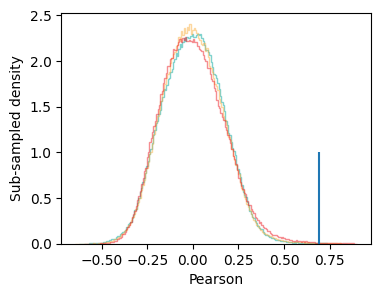


23 - pos_core_22
K562: 8732 instances
HepG2: 24710 instances
SKNSH: 8208 instances


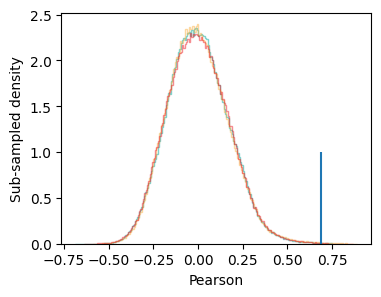


24 - pos_core_30
K562: 519 instances
HepG2: 34182 instances
SKNSH: 832 instances


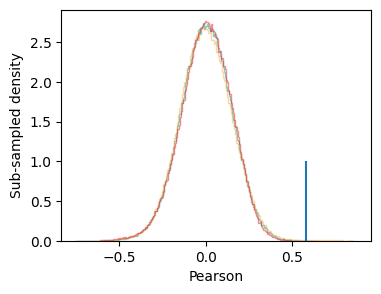


25 - pos_core_39
K562: 4074 instances
HepG2: 11702 instances
SKNSH: 11326 instances


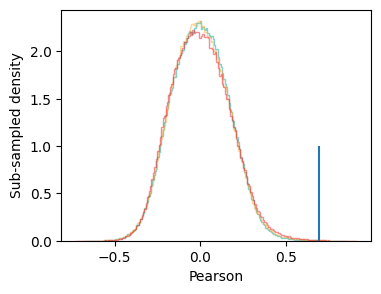


26 - pos_core_44
K562: 2196 instances
HepG2: 5597 instances
SKNSH: 7660 instances


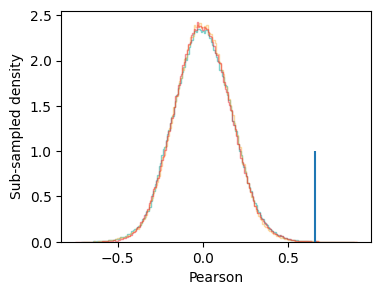


27 - pos_core_57b
K562: 3313 instances
HepG2: 1298 instances
SKNSH: 8355 instances


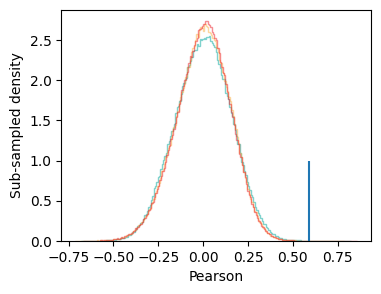


28 - pos_core_4
K562: 805 instances
HepG2: 35893 instances
SKNSH: 199 instances


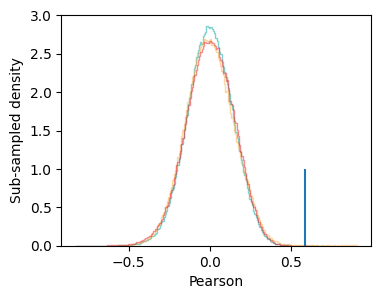


29 - streme_cluster__7_25_28
K562: 33691 instances
HepG2: 68759 instances
SKNSH: 49906 instances


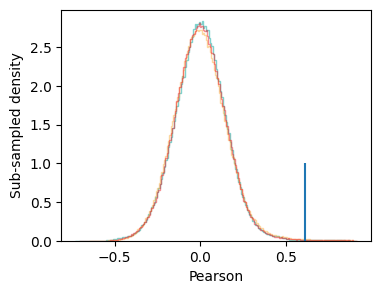


30 - pos_core_14
K562: 4191 instances
HepG2: 4902 instances
SKNSH: 5500 instances


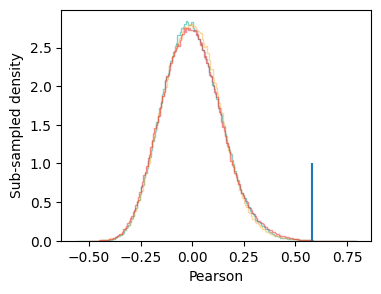


31 - pos_core_21
K562: 2460 instances
HepG2: 20410 instances
SKNSH: 281 instances


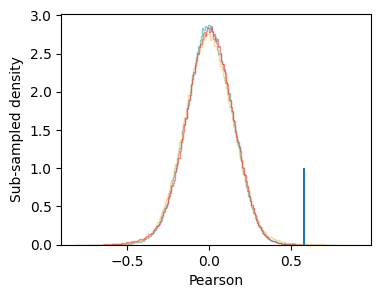


32 - pos_core_46
K562: 6178 instances
HepG2: 7866 instances
SKNSH: 6231 instances


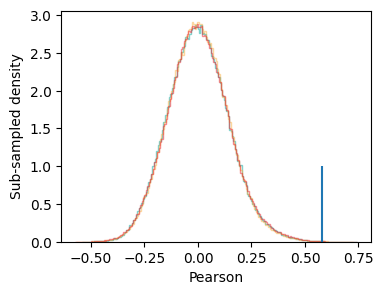


33 - pos_core_3
K562: 1728 instances
HepG2: 38359 instances
SKNSH: 445 instances


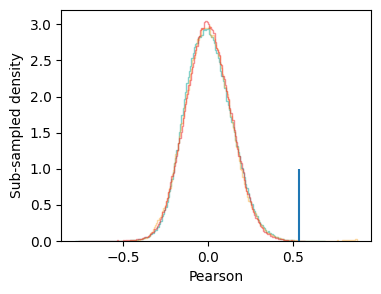


34 - pos_core_12
K562: 635 instances
HepG2: 7943 instances
SKNSH: 9832 instances


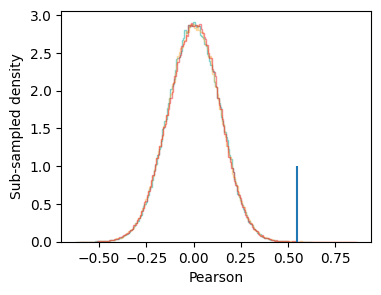


35 - pos_core_34
K562: 16426 instances
HepG2: 27204 instances
SKNSH: 24223 instances


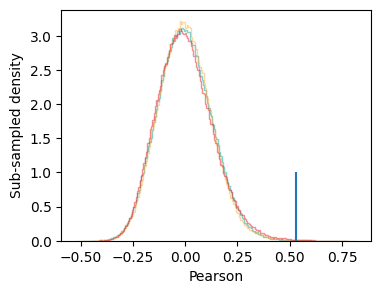


36 - pos_core_16
K562: 644 instances
HepG2: 41300 instances
SKNSH: 225 instances


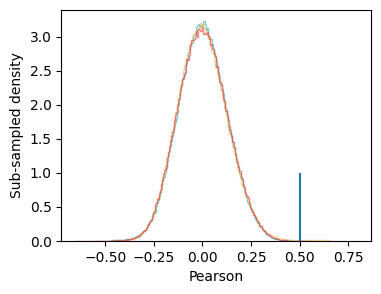


CPU times: user 2h 49min 38s, sys: 22min 33s, total: 3h 12min 11s
Wall time: 50min 16s


In [ ]:
%%time
#pearson_threshold = 0.7
padding = 5

zero_padding = torch.zeros(*all_hyp_contributions.shape[:3], padding)
all_hyp_contributions_padded = torch.cat([zero_padding, all_hyp_contributions, zero_padding], dim=-1)

motif_legth_set = np.unique([scores.shape[-1] for scores in fwd_motif_hyp_scores])

count = 1
all_motif_lengths = np.array([scores.shape[-1] for scores in fwd_motif_hyp_scores])
all_motif_instances_dict = {}
for window_len in motif_legth_set:     #unselect
    all_window_hyp_contribtutions = [all_hyp_contributions_padded[..., torch.arange(position, position + window_len)] \
                                    for position in range(all_hyp_contributions_padded.shape[-1] - window_len)]
    all_window_hyp_contribtutions = torch.stack(all_window_hyp_contribtutions, dim=2)
    all_window_hyp_contribtutions = all_window_hyp_contribtutions.flatten(1, 2)

    max_scores = torch.amax(all_window_hyp_contribtutions.abs(), dim=(-2,-1)).reshape(3, -1, 1, 1)
    all_window_hyp_contribtutions_normal = all_window_hyp_contribtutions / max_scores

    length_motif_idxs = np.where(all_motif_lengths == window_len)[0]
    for motif_idx in length_motif_idxs:   #unselect
        motif_id = motif_ids[motif_idx]
        fwd_filter = fwd_motif_hyp_scores[motif_idx]
        fwd_filter = fwd_filter / fwd_filter.abs().max()    #not relevant anymore
        rev_filter = rev_motif_hyp_scores[motif_idx]
        rev_filter = rev_filter / rev_filter.abs().max()     #not relevant anymore
        print(f'{count} - {motif_id}')
        count += 1

        plt.figure(figsize=(4,3))
        motif_instances_dict = {}
        for cell_idx, cell_type in enumerate(cell_types):   #unselect
            cell_window_hyp_contribtutions_normal = all_window_hyp_contribtutions_normal[cell_idx, ...]
            #--- Forward matches ---
            fwd_motif_pearsons = pearson_correlation_windows(cell_window_hyp_contribtutions_normal, fwd_filter)
            fwd_motif_pearsons = fwd_motif_pearsons.unflatten(0, (75000, all_hyp_contributions_padded.shape[-1] - window_len))

            pearson_threshold = min(0.75, torch.round(fwd_motif_pearsons.mean() + 4 * fwd_motif_pearsons.std(), decimals=2).item())

            fwd_threshold_filter = (fwd_motif_pearsons > pearson_threshold)
            fwd_passing_pearsons = fwd_motif_pearsons[fwd_threshold_filter]
            fwd_passing_idxs = torch.where(fwd_threshold_filter)
            fwd_passing_seq_idxs = fwd_passing_idxs[0]
            fwd_passing_motif_starts = fwd_passing_idxs[1] - padding
            fwd_passing_motif_stops = fwd_passing_motif_starts + window_len

            #--- Reverse complement matches ---
            rev_motif_pearsons = pearson_correlation_windows(cell_window_hyp_contribtutions_normal, rev_filter)
            rev_motif_pearsons = rev_motif_pearsons.unflatten(0, (75000, all_hyp_contributions_padded.shape[-1] - window_len))

            rev_threshold_filter = (rev_motif_pearsons > pearson_threshold)
            rev_passing_pearsons = rev_motif_pearsons[rev_threshold_filter]
            rev_passing_idxs = torch.where(rev_threshold_filter)
            rev_passing_seq_idxs = rev_passing_idxs[0]
            rev_passing_motif_starts = rev_passing_idxs[1] - padding
            rev_passing_motif_stops = rev_passing_motif_starts + window_len

            motif_instances_dict[cell_type] = {'fwd': [fwd_passing_seq_idxs, fwd_passing_motif_starts, fwd_passing_motif_stops, fwd_passing_pearsons],
                                               'rev':[rev_passing_seq_idxs, rev_passing_motif_starts, rev_passing_motif_stops, rev_passing_pearsons],
                                               }

            print(f'{cell_type}: {len(fwd_passing_seq_idxs) + len(rev_passing_seq_idxs)} instances')

            sampled_pearsons = np.random.choice(fwd_motif_pearsons.flatten(0,1).reshape(-1).numpy(), size=500000)
            plt.hist(sampled_pearsons, bins=200, alpha=0.5, density=True, histtype='step', color=cell_colors[cell_idx])

        plt.xlabel('Pearson')
        plt.ylabel('Sub-sampled density')
        plt.vlines(pearson_threshold, 0, 1)
        plt.show()
        print()

        all_motif_instances_dict[motif_id] = motif_instances_dict

torch.save(all_motif_instances_dict, '/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributionspearson_contribution_fimo_adaptive_threshold.pt')

In [ ]:
all_df_to_concat = []
for motif_idx, motif_name in enumerate(custom_motif_names):
    motif_id = motif_ids[motif_idx]
    motif_instances_dict = all_motif_instances_dict[motif_id]
    for cell_type in cell_types:
        cell_instances_dict = motif_instances_dict[cell_type]
        for strand in ['fwd', 'rev']:
            df_to_append = pd.DataFrame(columns=['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand', 'cell_type', 'gradients_pearson'])
            passing_seq_idxs = cell_instances_dict[strand][0].tolist()
            passing_motif_starts = cell_instances_dict[strand][1].tolist()
            passing_motif_stops = cell_instances_dict[strand][2].tolist()
            passing_pearsons = cell_instances_dict[strand][3].tolist()

            seq_ids = coda_library_df.iloc[passing_seq_idxs]['ID'].tolist()

            df_to_append['sequence_name'] = seq_ids
            df_to_append['start'] = passing_motif_starts
            df_to_append['stop'] = passing_motif_stops
            df_to_append['strand'] = strand
            df_to_append['cell_type'] = cell_type
            df_to_append['motif_id'] = motif_id
            df_to_append['motif_alt_id'] = motif_name
            df_to_append['gradients_pearson'] = passing_pearsons

            all_df_to_concat.append(df_to_append)

contribution_fimo_df = pd.concat(all_df_to_concat).reset_index(drop=True)

contribution_fimo_df['start'] = contribution_fimo_df['start'].astype(int)
contribution_fimo_df['stop'] = contribution_fimo_df['stop'].astype(int)

contribution_fimo_df.to_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_full.tsv', sep='\t', index=None)

# contribution_fimo_df['gradients_pearson'] = pd.to_numeric(contribution_fimo_df['gradients_pearson'])

# # Group by the specified columns and get the index of the maximum 'gradients_pearson' in each group
# idx_max = contribution_fimo_df.groupby(['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand'])['gradients_pearson'].idxmax()

# # Use the obtained indices to create the sub-dataframe
# fimo_df = contribution_fimo_df.loc[idx_max]

# fimo_df.to_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t', index=None)

fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/core_motif_contribution_fimolike.tsv', sep='\t')
print(len(fimo_df), len(fimo_df['sequence_name'].unique()))

1228369 74991


In [ ]:
contribution_fimo_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,cell_type,gradients_pearson
0,pos_core_0b,GATA3,20211207_63610__124703__64::sa__hepg2__0,40,49,fwd,K562,0.790668
1,pos_core_0b,GATA3,20211207_63610__124703__121::sa__hepg2__0,66,75,fwd,K562,0.779980
2,pos_core_0b,GATA3,20211207_63610__124703__133::sa__hepg2__0,31,40,fwd,K562,0.807156
3,pos_core_0b,GATA3,20211207_63610__124703__141::sa__hepg2__0,180,189,fwd,K562,0.819729
4,pos_core_0b,GATA3,20211207_63610__124703__191::sa__hepg2__0,70,79,fwd,K562,0.748253
...,...,...,...,...,...,...,...,...
1911971,streme_cluster__42,*HSF1,chr17:893500-893700,3,13,rev,SKNSH,0.642015
1911972,streme_cluster__42,*HSF1,chr1:789500-789700,142,152,rev,SKNSH,0.635014
1911973,streme_cluster__42,*HSF1,chr22:16352800-16353000,125,135,rev,SKNSH,0.670653
1911974,streme_cluster__42,*HSF1,chr20:31188400-31188600,193,203,rev,SKNSH,0.665227


In [ ]:
seq_ids = ['20211212_75659__621411__391::fsp__sknsh__0', #N5 #BODA_SKNSH_Test1
                '20211206_24503__33072627__1223::al__hepg2__0', #L2

                '20211212_45907__313665__213::fsp__hepg2__0', #BODA_HEPG2_Test1
                '20211212_61436__944763__262::fsp__hepg2__0', #BODA_HEPG2_Test2
                '20211207_212124__46481152__2927::al__sknsh__0', #N3 #BODA_SKNSH_Test2
                '20211207_152258__777391__191::sa__sknsh__0', #N2
                '20211207_212124__46481152__3404::al__sknsh__0', #N4
                '20211206_24503__33072627__1816::al__hepg2__0', #L3
                '20211207_100944__255626__132::sa__hepg2__0', #L4

                '20211207_63610__124703__1517::sa__hepg2__0', #?
                '20211207_212124__46481152__3727::al__sknsh__0', #L?

                '20211212_55149__346635__38::fsp__hepg2__0',
                '20211212_52639__969454__182::fsp__hepg2__0',
                '20211212_12620__229779__1223::fsp__hepg2__0',
                '20211212_55149__346635__486::fsp__hepg2__0',
                '20211212_55149__346635__150::fsp__hepg2__0',
                '20211212_52639__969454__185::fsp__hepg2__0',
                '20211212_12620__229779__1181::fsp__hepg2__0',
                '20211212_12620__229779__56::fsp__hepg2__0',
                ]

intersection_threshold = 200
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    for cell_idx, cell_type in enumerate(cell_types):
        seq_scan_df = contribution_fimo_df[(contribution_fimo_df['sequence_name'] == seq_id) & (contribution_fimo_df['cell_type'] == cell_type)]
        seq_scan_df = seq_scan_df.sort_values('gradients_pearson', ascending=False).reset_index(drop=True)

        seq_contributions = all_contributions[cell_idx, seq_idx, ...]
        y_max = seq_contributions.max()

        find_motif_names  = []
        print_motif_names = []
        motifs_start_ends = []
        orientations      = []
        cover_set         = set()
        num_hits = len(seq_scan_df)
        for i in range(num_hits):
            hit_row = seq_scan_df.iloc[i]
            m_start, m_end = max(0, hit_row['start']), min(200, hit_row['stop'])
            motif_range = set(np.arange(m_start, m_end))
            motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
            pos_contribution = motif_contributions.max()
            neg_contribution = motif_contributions.min()
            contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
            if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
                find_motif_names.append(hit_row['motif_id'])
                print_motif_names.append(hit_row['motif_alt_id'])
                motifs_start_ends.append((m_start, m_end))
                orientations.append(hit_row['strand'])
                cover_set = cover_set | motif_range
            find_motif_short_names = [name + ' ' + str(strand) for name, strand in zip(find_motif_names, orientations)]
            print_short_names = [name + ' (' + str(strand) + ')' for name, strand in zip(print_motif_names, orientations)]

        matrix_plot = seq_contributions.clone()
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            #text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            text = f'{print_short_names[idx]}'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
seq_ids = ['20211212_75659__621411__391::fsp__sknsh__0', #N5 #BODA_SKNSH_Test1
                '20211206_24503__33072627__1223::al__hepg2__0', #L2

                '20211212_45907__313665__213::fsp__hepg2__0', #BODA_HEPG2_Test1
                '20211212_61436__944763__262::fsp__hepg2__0', #BODA_HEPG2_Test2
                '20211207_212124__46481152__2927::al__sknsh__0', #N3 #BODA_SKNSH_Test2
                '20211207_152258__777391__191::sa__sknsh__0', #N2
                '20211207_212124__46481152__3404::al__sknsh__0', #N4
                '20211206_24503__33072627__1816::al__hepg2__0', #L3
                '20211207_100944__255626__132::sa__hepg2__0', #L4

                '20211207_63610__124703__1517::sa__hepg2__0', #?
                '20211207_212124__46481152__3727::al__sknsh__0', #L?

                '20211212_55149__346635__38::fsp__hepg2__0',
                '20211212_52639__969454__182::fsp__hepg2__0',
                '20211212_12620__229779__1223::fsp__hepg2__0',
                '20211212_55149__346635__486::fsp__hepg2__0',
                '20211212_55149__346635__150::fsp__hepg2__0',
                '20211212_52639__969454__185::fsp__hepg2__0',
                '20211212_12620__229779__1181::fsp__hepg2__0',
                '20211212_12620__229779__56::fsp__hepg2__0',
                ]

intersection_threshold = 5
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(seq_ids):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    for cell_idx, cell_type in enumerate(cell_types):
        seq_scan_df = contribution_fimo_df[(contribution_fimo_df['sequence_name'] == seq_id) & (contribution_fimo_df['cell_type'] == cell_type)]
        seq_scan_df = seq_scan_df.sort_values('gradients_pearson', ascending=False).reset_index(drop=True)

        seq_contributions = all_contributions[cell_idx, seq_idx, ...]
        y_max = seq_contributions.max()

        find_motif_names  = []
        print_motif_names = []
        motifs_start_ends = []
        orientations      = []
        cover_set         = set()
        num_hits = len(seq_scan_df)
        for i in range(num_hits):
            hit_row = seq_scan_df.iloc[i]
            m_start, m_end = max(0, hit_row['start']), min(200, hit_row['stop'])
            motif_range = set(np.arange(m_start, m_end))
            motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
            pos_contribution = motif_contributions.max()
            neg_contribution = motif_contributions.min()
            contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
            if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
                find_motif_names.append(hit_row['motif_id'])
                print_motif_names.append(hit_row['motif_alt_id'])
                motifs_start_ends.append((m_start, m_end))
                orientations.append(hit_row['strand'])
                cover_set = cover_set | motif_range
            find_motif_short_names = [name + ' ' + str(strand) for name, strand in zip(find_motif_names, orientations)]
            print_short_names = [name + ' (' + str(strand) + ')' for name, strand in zip(print_motif_names, orientations)]

        matrix_plot = seq_contributions.clone()
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            #text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            text = f'{print_short_names[idx]}'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

#Motif hit analyses

In [ ]:
natural_methods = ['DHS', 'gs']

num_naturals = coda_library_df['method'].isin(natural_methods).sum()
num_synthetics = coda_library_df['method'].isin(['sa', 'al', 'fsp']).sum()
num_all_seqs = len(coda_library_df)
num_naturals, num_synthetics, num_all_seqs

natural_pcts = []
synthetic_pcts = []
total_pcts = []
for motif_id in tqdm(motif_ids):
    hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    motif_boda2_df = coda_library_df[coda_library_df['ID'].isin(hit_seqs)].reset_index(drop=True)
    motif_num_naturals = motif_boda2_df['method'].isin(natural_methods).sum()
    motif_num_synthetics = motif_boda2_df['method'].isin(['sa', 'al', 'fsp']).sum()
    natural_pcts.append(motif_num_naturals/num_naturals)
    synthetic_pcts.append(motif_num_synthetics/num_synthetics)
    total_pcts.append(len(motif_boda2_df)/num_all_seqs)

  0%|          | 0/36 [00:00<?, ?it/s]

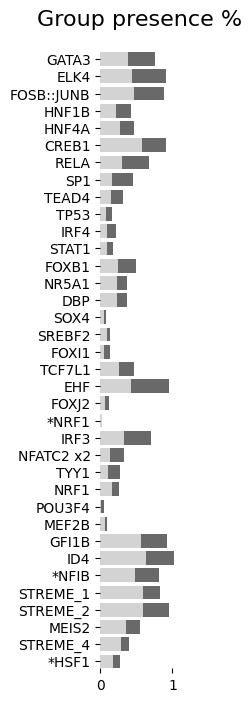

In [ ]:
num_motifs = len(motif_ids)
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs

clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]
clustered_natural_pcts = np.array(natural_pcts)[np.ix_(idx_clustering)]
clustered_synthetic_pcts = np.array(synthetic_pcts)[np.ix_(idx_clustering)]

plt.figure(figsize=(1,8))
b1 = plt.barh(clustered_motif_labels, clustered_synthetic_pcts, color="lightgray")
b2 = plt.barh(clustered_motif_labels, clustered_natural_pcts, left=clustered_synthetic_pcts, color="dimgray")

#plt.legend([b1, b2], ["Synthetics", "Naturals"], title="Group", fontsize=8, loc='best')
#plt.xlabel('Occurrence percentage', fontsize=12)
plt.gca().invert_yaxis()
plt.margins(y=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.yticks([])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig(f"/content/drive/MyDrive/figures/motif_usage.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
plt.title('Group presence %', y=1.03, fontsize=16)
plt.show()

In [ ]:
num_seqs_k562 = (coda_library_df['target_cell'] == 'k562').sum()
num_seqs_hepg2 = (coda_library_df['target_cell'] == 'hepg2').sum()
num_seqs_sknsh = (coda_library_df['target_cell'] == 'sknsh').sum()

k562_pcts = []
hepg2_pcts = []
sknsh_pcts = []
for motif_id in tqdm(motif_ids):
    hit_seqs = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    motif_boda2_df = coda_library_df[coda_library_df['ID'].isin(hit_seqs)].reset_index(drop=True)
    # k562_pcts.append( (motif_boda2_df['target_cell'] == 'k562').sum() / num_all_seqs )
    # hepg2_pcts.append( (motif_boda2_df['target_cell'] == 'hepg2').sum() / num_all_seqs )
    # sknsh_pcts.append( (motif_boda2_df['target_cell'] == 'sknsh').sum() / num_all_seqs )
    k562_pcts.append( (motif_boda2_df['target_cell'] == 'k562').sum() / num_seqs_k562 )
    hepg2_pcts.append( (motif_boda2_df['target_cell'] == 'hepg2').sum() / num_seqs_hepg2 )
    sknsh_pcts.append( (motif_boda2_df['target_cell'] == 'sknsh').sum() / num_seqs_sknsh )

  0%|          | 0/36 [00:00<?, ?it/s]

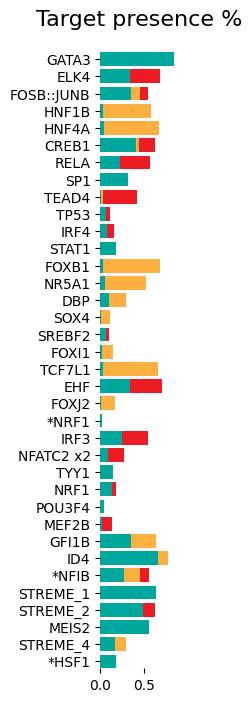

In [ ]:
idx_clustering = np.arange(0, num_motifs) #np.arange(0, num_motifs) #clustered_topic_idxs #clustered_motif_idxs
clustered_motif_labels = np.array(custom_motif_names)[np.ix_(idx_clustering)]

clustered_k562_pcts = np.array(k562_pcts)[np.ix_(idx_clustering)]
clustered_hepg2_pcts = np.array(hepg2_pcts)[np.ix_(idx_clustering)]
clustered_sknsh_pcts = np.array(sknsh_pcts)[np.ix_(idx_clustering)]

plt.figure(figsize=(1,8))
b3 = plt.barh(clustered_motif_labels, clustered_sknsh_pcts, color="#ED1C24")
b2 = plt.barh(clustered_motif_labels, clustered_hepg2_pcts, color="#FBB040")
b1 = plt.barh(clustered_motif_labels, clustered_k562_pcts, color='#00A79D')

#plt.legend([b1, b2], ["Naturals", "Synthetics"], title="Group", fontsize=8)
#plt.xlabel('Enrichment', fontsize=12)
plt.gca().invert_yaxis()
plt.margins(y=0)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#plt.yticks([])
#plt.xticks([])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)#, color='#002D72')
#plt.savefig(f"/content/drive/MyDrive/figures/motif_target_enrichment.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
plt.title('Target presence %', y=1.03, fontsize=16)
plt.show()

#Pearson-weighted motif contributions

In [ ]:
seq_list = coda_library_df['ID'].tolist()

id2idx_dict = dict(zip(coda_library_df.ID, coda_library_df.index))

all_motif_contributions = []
for motif_id in tqdm(motif_ids):
    motif_fimo_df = fimo_df[fimo_df['motif_id'] == motif_id]
    motif_starts = motif_fimo_df['start'].tolist()
    motif_stops = motif_fimo_df['stop'].tolist()
    #motif_weights = torch.Tensor((motif_fimo_df['score'] / motif_fimo_df['score'].sum()).to_numpy()).reshape(-1,1)

    motif_seq_ids = motif_fimo_df['sequence_name'].tolist()
    seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]

    weighted_motif_contributions = []
    iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
    for seq_idx, (start, stop) in iterator:
        if start <0 or stop>200:
            pass
        else:
            weighted_motif_contributions.append(all_contributions[:, seq_idx, ..., start:stop])
    motif_weights = torch.Tensor((motif_fimo_df['gradients_pearson'] / motif_fimo_df['gradients_pearson'].sum()).to_numpy()).reshape(-1,1)
    weighted_motif_contributions = torch.stack(weighted_motif_contributions).sum(dim=(2,3)).mean(dim=0)#(torch.stack(weighted_motif_contributions).sum(dim=[2,3]) * motif_weights).sum(dim=0)
    all_motif_contributions.append(weighted_motif_contributions)

all_motif_contributions = torch.stack(all_motif_contributions)

  0%|          | 0/36 [00:00<?, ?it/s]

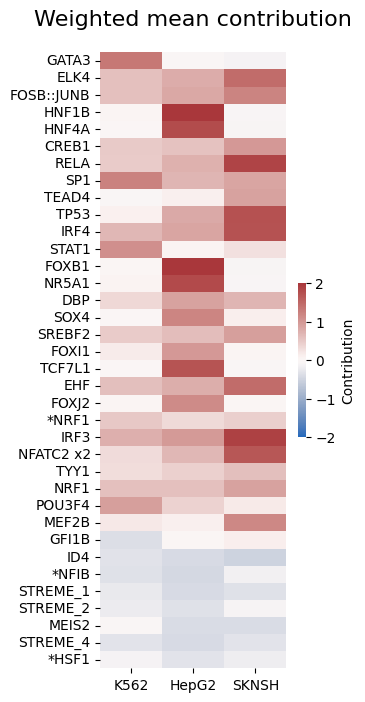

In [ ]:
plt.figure(figsize=(3,8))
sns.heatmap(all_motif_contributions, vmin=-2, vmax=2, cmap="vlag",
            cbar_kws={'label': 'Contribution', "shrink": .25})
plt.yticks(np.arange(0, len(custom_motif_names))+0.5, labels=custom_motif_names, rotation=0)
plt.xticks(np.arange(3)+0.5, labels=['K562', 'HepG2', 'SKNSH'])
plt.title('Weighted mean contribution', y=1.03, fontsize=16)
plt.show()

#Co-occurrence

In [ ]:
import bottleneck as bn

def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

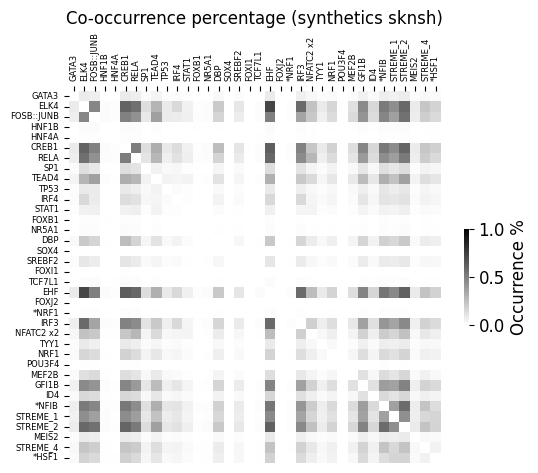

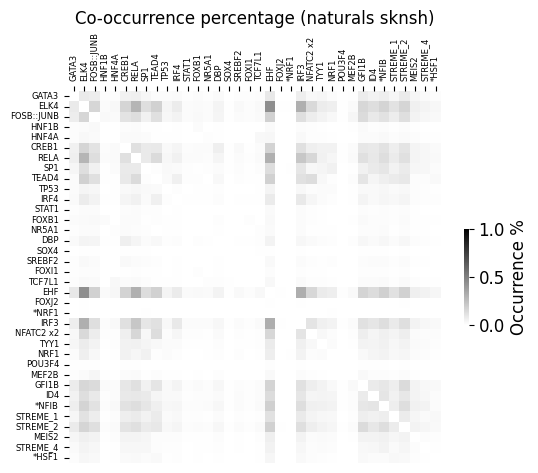

In [ ]:
target_cells = ['sknsh'] #['k562', 'hepg2', 'sknsh']

#--- Co-occurrence difference
motif_list = motif_ids.copy()
ultimate_ids = custom_motif_names.copy()
precise_library_df = coda_library_df.copy()


#--- Group 1
methods = ['fsp', 'al', 'sa']
#methods = ['DHS', 'gs']
#methods = ['DHS', 'gs', 'fsp', 'al', 'sa']
 #['k562', 'hepg2', 'sknsh']

group_df = precise_library_df[precise_library_df['method'].isin(methods) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)
#-For non-penalized
#group_df = group_df[group_df['round'].isin([0])].reset_index(drop=True)

for motif_id in tqdm(motif_list):
    motif_seq_set = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    seq_filter = group_df['ID'].isin(motif_seq_set)
    group_df[motif_id] = 0
    group_df.loc[seq_filter, motif_id] = 1

group_df.rename(dict(zip(motif_list, ultimate_ids)), axis=1, inplace=True)
num_seqs_1 = len(group_df)

all_sequence_sets_1 = []
coocurrence_counts = np.zeros((num_motifs, num_motifs))
for i in tqdm(range(num_motifs)):
    row_sequence_sets = []
    for j in range(i+1, num_motifs):
        coocurrence_filter = (group_df[ultimate_ids[i]] == 1) & (group_df[ultimate_ids[j]] == 1)
        seq_ids = group_df[coocurrence_filter]['ID'].tolist()
        coocurrence_counts[i,j] = len(seq_ids)
        row_sequence_sets.append(seq_ids)
    all_sequence_sets_1.append((row_sequence_sets))
coocurrence_pcts = coocurrence_counts / num_seqs_1
coocurrence_pcts = coocurrence_pcts + coocurrence_pcts.T

sorted_coocurrence_1 = coocurrence_pcts #[np.ix_(clustered_motif_idxs, clustered_motif_idxs)]

#--- Group 2
#methods = ['fsp', 'al', 'sa']
methods = ['DHS', 'gs']
#methods = ['DHS']
#methods = ['DHS', 'gs', 'fsp', 'al', 'sa']

group_df = precise_library_df[precise_library_df['method'].isin(methods) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)

#-For penalized:
# group_df = precise_library_df[precise_library_df['round'].isin([1,2,3,4,5]) & precise_library_df['target_cell'].isin(target_cells)].reset_index(drop=True)
# group_df = group_df[group_df['method'].isin(['fsp'])].reset_index(drop=True)
#---

for motif_id in tqdm(motif_list):
    motif_seq_set = fimo_df[fimo_df['motif_id'] == motif_id]['sequence_name'].unique()
    seq_filter = group_df['ID'].isin(motif_seq_set)
    group_df[motif_id] = 0
    group_df.loc[seq_filter, motif_id] = 1

group_df.rename(dict(zip(motif_list, ultimate_ids)), axis=1, inplace=True)
num_seqs_2 = len(group_df)

all_sequence_sets_2 = []
coocurrence_counts = np.zeros((num_motifs, num_motifs))
for i in tqdm(range(num_motifs)):
    row_sequence_sets = []
    for j in range(i+1, num_motifs):
        coocurrence_filter = (group_df[ultimate_ids[i]] == 1) & (group_df[ultimate_ids[j]] == 1)
        seq_ids = group_df[coocurrence_filter]['ID'].tolist()
        coocurrence_counts[i,j] = len(seq_ids)
        row_sequence_sets.append(seq_ids)
    all_sequence_sets_2.append((row_sequence_sets))
coocurrence_pcts = coocurrence_counts / num_seqs_2
coocurrence_pcts = coocurrence_pcts + coocurrence_pcts.T

sorted_coocurrence_2 = coocurrence_pcts #[np.ix_(clustered_motif_idxs, clustered_motif_idxs)]

figsize = (6, 5)
# all_ticks = np.arange(0, num_motifs) + 0.5
# fit_data = distance_matrix.copy()
# above_distance_matrix = fit_data * (sorted_coocurrence_1 - sorted_coocurrence_2)
# #above_distance_matrix = (sorted_coocurrence_1 - sorted_coocurrence_2)
# # with plt.style.context('fivethirtyeight'):
# #     plt.figure(figsize=figsize)
# #     g = sns.heatmap(above_distance_matrix, square=True, vmin=-0.5, vmax=0.5, cmap="viridis",
# #                     cbar_kws={'label': '', "shrink": .25})
# #     plt.xticks(all_ticks, labels=custom_motif_names, rotation=90, fontsize=6)
# #     plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
# #     g.figure.axes[-1].yaxis.label.set_size(12)
# #     g.figure.axes[-1].tick_params(labelsize=12)
# #     g.xaxis.tick_top()
# #     # g.yaxis.tick_right()
# #     plt.grid(False)
# #     plt.title('Co-occurrence weighted by motif distance')

# #     plt.show()

plt.figure(figsize=figsize)
g = sns.heatmap(sorted_coocurrence_1, square=True, vmin=0, vmax=1, cmap="binary",
                cbar_kws={'label': 'Occurrence %', "shrink": .25})
plt.xticks(all_ticks, labels=custom_motif_names, rotation=90, fontsize=6)
plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
g.figure.axes[-1].yaxis.label.set_size(12)
g.figure.axes[-1].tick_params(labelsize=12)
g.xaxis.tick_top()
# g.yaxis.tick_right()
plt.grid(False)
plt.title('Co-occurrence percentage (synthetics ' + ' '.join(target_cells) + ')')
plt.show()

plt.figure(figsize=figsize)
g = sns.heatmap(sorted_coocurrence_2, square=True, vmin=0, vmax=1, cmap="binary",
                cbar_kws={'label': 'Occurrence %', "shrink": .25})
plt.xticks(all_ticks, labels=custom_motif_names, rotation=90, fontsize=6)
plt.yticks(all_ticks, labels=custom_motif_names, rotation=0, fontsize=6)
g.figure.axes[-1].yaxis.label.set_size(12)
g.figure.axes[-1].tick_params(labelsize=12)
g.xaxis.tick_top()
# g.yaxis.tick_right()
plt.grid(False)
plt.title('Co-occurrence percentage (naturals ' + ' '.join(target_cells) + ')')
plt.show()

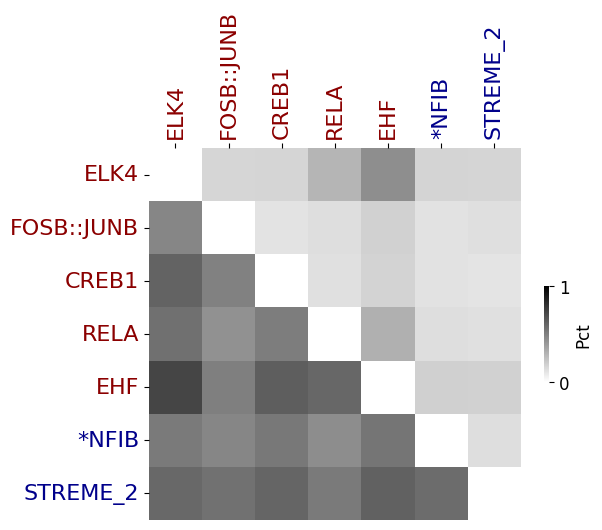

In [ ]:
n_top = 20 #20 #50

#---Motif label colors
contrib_means = all_motif_contributions.mean(dim=-1)
pos_idxs = torch.where(contrib_means > 0)[0].tolist()
neg_idxs = torch.where(contrib_means <= 0)[0].tolist()
motif_colors = ['darkred' if (i in pos_idxs) else 'darkblue' for i in range(82)]

some_matrix = np.abs(sorted_coocurrence_1 - sorted_coocurrence_2) #fit_data * (sorted_coocurrence_1 - sorted_coocurrence_2)
top_idxs = top_n_indexes(some_matrix, n_top)
top_idxs = sorted(set([item for t in top_idxs for item in t]))

reduced_ticks = np.arange(0.5, len(top_idxs) + 0.5, 1)
reduced_labels = [clustered_motif_labels[j] for j in top_idxs]
reduced_colors = [motif_colors[j] for j in top_idxs]

#---Cooccurrence
plot_matrix_l = (sorted_coocurrence_1)[np.ix_(top_idxs, top_idxs)]
plot_matrix_u = (sorted_coocurrence_2)[np.ix_(top_idxs, top_idxs)]

mask_u = np.zeros_like(plot_matrix_u, dtype=bool)
mask_u[np.triu_indices_from(mask_u)] = True

mask_l = np.zeros_like(plot_matrix_l, dtype=bool)
mask_l[np.tril_indices_from(mask_l)] = True

plot_matrix = mask_l * plot_matrix_l + mask_u * plot_matrix_u

#zeros = np.zeros_like(plot_matrix, dtype=bool)
mask = np.eye(len(top_idxs))

max_color = 1 #np.round(plot_matrix.max(), 2) #0.45 #np.round(plot_matrix.max(), 2)
figsize = (6, 5)
with plt.style.context('fast'):
    plt.figure(figsize=figsize)
    g = sns.heatmap(plot_matrix, square=True, vmin=0, vmax=max_color, cmap="binary", mask=mask,
                    cbar_kws={'label': 'Pct', "shrink": .25, "ticks":[0, max_color]})
    plt.xticks(reduced_ticks, labels=reduced_labels, rotation=90, fontsize=16)
    plt.yticks(reduced_ticks, labels=reduced_labels, rotation=0, fontsize=16)

    g.figure.axes[-1].yaxis.label.set_size(12)
    g.figure.axes[-1].tick_params(labelsize=12)
    g.xaxis.tick_top()
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), reduced_colors):
        ticklabel.set_color(tickcolor)
    # g.yaxis.tick_right()
    plt.grid(False)
    #plt.title('Co-occurrence weighted by motif distance')
    save_path = f'/content/drive/MyDrive/figures/motif_cooccurrence/top50_motif_cooccurrence_raw_{target_cells[0]}_v2.pdf'
    #plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
    plt.show()

#----
# top_idx_set = set(sorted([tuple(sorted(idx_pair)) for idx_pair in top_n_indexes(some_matrix, n_top)]))

# topn_seq_set_1 = []
# topn_seq_set_2 = []
# for idx_pair in top_idx_set:
#     topn_seq_set_1 += all_sequence_sets_1[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]
#     topn_seq_set_2 += all_sequence_sets_2[idx_pair[0]][idx_pair[1] - idx_pair[0] - 1]

# set_pct_1 = len(set(topn_seq_set_1))/num_seqs_1
# set_pct_2 = len(set(topn_seq_set_2))/num_seqs_2
# print(np.round(100*set_pct_1, 1), np.round(100*set_pct_2, 1))

# global_id_set_1 += list(set(topn_seq_set_1))
# global_id_set_2 += list(set(topn_seq_set_2))

#Type/token

In [ ]:
matches = fimo_df.groupby('sequence_name').motif_id.apply(list).reset_index()
matches.rename({'sequence_name':'ID'}, axis=1, inplace=True)

In [ ]:
matches_df = matches.merge(coda_library_df, on='ID', how='inner')

matches_df['token'] = matches_df.progress_apply(lambda x: len(x['motif_id']), axis=1)
matches_df['type'] = matches_df.progress_apply(lambda x: len(set(x['motif_id'])), axis=1)

matches_df['type/token'] = matches_df['type'] / matches_df['token']

  0%|          | 0/74991 [00:00<?, ?it/s]

  0%|          | 0/74991 [00:00<?, ?it/s]

In [ ]:
dhs_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/DHS.Control.Satellite.Simple.Repeats.txt', sep='\t')
mal_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/Malinois.Natural.Satellite.Simple.Repeats.txt', sep='\t')

dhs_annotation_df['Seq ID'] = [x[0] for x in dhs_annotation_df['Seq ID'].str.split(':')]
mal_annotation_df['Seq ID'] = [(':').join(x[:2]) for x in mal_annotation_df['Seq ID'].str.split(':').tolist()]

repetitive_seqs = set(dhs_annotation_df['Seq ID'].tolist() + mal_annotation_df['Seq ID'].tolist())

In [ ]:
row_filter = matches_df['method'].isin(['DHS', 'gs'])
truncated_ids = [x[0] for x in matches_df.loc[row_filter]['ID'].str.split('::').tolist()]
matches_df.loc[row_filter, 'truncated_id'] = truncated_ids

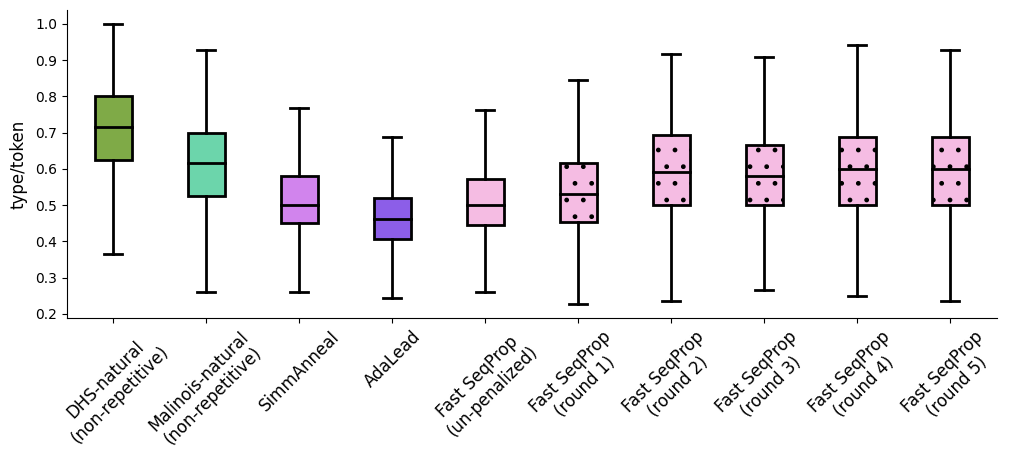

In [ ]:
conditon_1 = matches_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (matches_df['round'] == 0)
condition_2 = matches_df['method'] == 'fsp'
plot_df = matches_df[conditon_1 | condition_2].reset_index(drop=True)

plot_df = plot_df[~plot_df['truncated_id'].isin(repetitive_seqs)].reset_index(drop=True)


row_filter = plot_df['method'] == 'fsp'
plot_df.loc[row_filter, 'method'] = 'Fast SeqProp\nround ' + plot_df[row_filter]['round'].astype(str)

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order = ['DHS', 'gs', 'sa', 'al', 'Fast SeqProp\nround 0', 'Fast SeqProp\nround 1',
       'Fast SeqProp\nround 2', 'Fast SeqProp\nround 3',
       'Fast SeqProp\nround 4', 'Fast SeqProp\nround 5']
ordered_colors = ['#81BA37', '#5AE7AE', '#D972FF', '#8447FF'] + 6*['#FFB2E6']
hatches = 5*[''] + 5*['.']
with plt.style.context('fast'):
    plt.figure(figsize=(12,4))
    mpl.rcParams['lines.linewidth'] = 2.0
    g = sns.boxplot(data=plot_df, x='method', y='type/token', showfliers=False, order=order, width=0.4, palette=ordered_colors, **PROPS)
    patches = [patch for patch in g.patches if type(patch) == mpl.patches.PathPatch]
    h = hatches * (len(patches) // len(hatches))
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        patch.set_edgecolor('k')
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    plt.xlabel('')
    g.set_xticklabels(['DHS-natural\n(non-repetitive)', 'Malinois-natural\n(non-repetitive)', 'SimmAnneal', 'AdaLead', 'Fast SeqProp\n(un-penalized)',
                       'Fast SeqProp\n(round 1)', 'Fast SeqProp\n(round 2)', 'Fast SeqProp\n(round 3)', 'Fast SeqProp\n(round 4)', 'Fast SeqProp\n(round 5)'],
                      fontsize=12, rotation=45)
    plt.ylabel('type/token', labelpad=5, fontsize=12)
    savepath = f'/content/drive/MyDrive/figures/type_token/type_token_all_methods_boxplot.pdf'
    #plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.show()

#Hits in repetitive elements

In [ ]:
dhs_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/DHS.Control.Satellite.Simple.Repeats.txt', sep='\t')
mal_annotation_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/satellite_repeat_annotations/Malinois.Natural.Satellite.Simple.Repeats.txt', sep='\t')

dhs_annotation_df['Seq ID'] = [x[0] for x in dhs_annotation_df['Seq ID'].str.split(':')]
mal_annotation_df['Seq ID'] = [(':').join(x[:2]) for x in mal_annotation_df['Seq ID'].str.split(':').tolist()]

repetitive_seqs = list(set(dhs_annotation_df['Seq ID'].tolist() + mal_annotation_df['Seq ID'].tolist()))

In [ ]:
intersection_threshold = 200
cmap = plt.get_cmap('rainbow', len(motif_ids))

color_dict = dict(zip(2 * motif_ids, 2*[cmap(i) for i in range(len(motif_ids))]))

for order_idx, seq_id in enumerate(repetitive_seqs[:20]):

    seq_df = coda_library_df[coda_library_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}')

    for cell_idx, cell_type in enumerate(cell_types):
        seq_scan_df = contribution_fimo_df[(contribution_fimo_df['sequence_name'] == seq_id) & (contribution_fimo_df['cell_type'] == cell_type)]
        seq_scan_df = seq_scan_df.sort_values('gradients_pearson', ascending=False).reset_index(drop=True)

        seq_contributions = all_contributions[cell_idx, seq_idx, ...]
        y_max = seq_contributions.max()

        find_motif_names  = []
        print_motif_names = []
        motifs_start_ends = []
        orientations      = []
        cover_set         = set()
        num_hits = len(seq_scan_df)
        for i in range(num_hits):
            hit_row = seq_scan_df.iloc[i]
            m_start, m_end = max(0, hit_row['start']), min(200, hit_row['stop'])
            motif_range = set(np.arange(m_start, m_end))
            motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
            pos_contribution = motif_contributions.max()
            neg_contribution = motif_contributions.min()
            contribution_condition = True #(pos_contribution > 0.06) or (neg_contribution < -0.02)
            if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
                find_motif_names.append(hit_row['motif_id'])
                print_motif_names.append(hit_row['motif_alt_id'])
                motifs_start_ends.append((m_start, m_end))
                orientations.append(hit_row['strand'])
                cover_set = cover_set | motif_range
            find_motif_short_names = [name + ' ' + str(strand) for name, strand in zip(find_motif_names, orientations)]
            print_short_names = [name + ' (' + str(strand) + ')' for name, strand in zip(print_motif_names, orientations)]

        matrix_plot = seq_contributions.clone()
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=1.3, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            try:
                color = color_dict[motif_name]
            except:
                color = color_dict[f'{motif_name}b']
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            #text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            text = f'{print_short_names[idx]}'
            x = motifs_start_ends[idx][0]
            y = contrib_min_maxs[idx][1] + 0.05
            plt.text(x, y, text, fontsize=16, rotation=90)
        plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
seq_scan_df = seq_scan_df.sort_values('gradients_pearson', ascending=False).reset_index(drop=True)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,cell_type,gradients_pearson
325537,pos_core_2,FOSB::JUNB,chr17:21977800-21978000,84,95,fwd,SKNSH,0.914018
359799,pos_core_2,FOSB::JUNB,chr17:21977800-21978000,84,95,rev,SKNSH,0.908982
325536,pos_core_2,FOSB::JUNB,chr17:21977800-21978000,29,40,fwd,SKNSH,0.829983
359798,pos_core_2,FOSB::JUNB,chr17:21977800-21978000,29,40,rev,SKNSH,0.828988
1884174,streme_cluster__37,STREME_4,chr17:21977800-21978000,134,144,fwd,SKNSH,0.763115
1894451,streme_cluster__37,STREME_4,chr17:21977800-21978000,134,144,rev,SKNSH,0.763115
